In [1]:
import os
import numpy as np
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from libs import utils, gif, datasets, dataset_utils, vae, dft

%matplotlib inline


Using TensorFlow backend.


## Load

In [2]:
data_directory = './data/pokemon/jpeg/'
filenames = [os.path.join(data_directory, file_i)
              for file_i in os.listdir(data_directory)
              if '.jpg' in file_i]

In [3]:
nb_clip = 10000
filenames = filenames[:nb_clip]
imgs = [plt.imread(f) for f in filenames]

Xs = np.array(imgs)

print(Xs.shape)

(2240, 64, 64, 3)


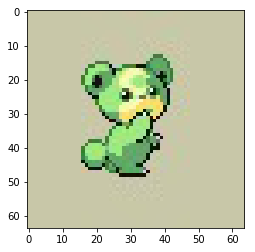

In [4]:
plt.imshow(Xs[5])

In [5]:
def preprocess(x):
    x = x.astype('float32') / 255.
    return x.reshape(-1, np.prod(x.shape[1:])) # flatten

In [6]:
X_train, X_test = train_test_split(Xs, test_size=0.3)
X_train = preprocess(X_train)
X_test  = preprocess(X_test)
print(X_train[0])

[ 0.7647059   0.57254905  0.64705884 ...,  0.7764706   0.56470591
  0.65882355]


## Autoencoder

In [7]:
n_epochs = 200
batch_size = 128

In [8]:
def convolutional_autoencoder():
    # encoding
    input_img = Input(shape=(64, 64, 3))  # adapt this if using `channels_first` image data format
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # decoding
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    # autoencoder
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.summary()
    
    return autoencoder

def get_callbacks(model_filepath, log_dir, patience=10):
    earlystopping = EarlyStopping('val_loss', patience=patience, mode="min")
    checkpointer = ModelCheckpoint(filepath=model_filepath,
                               verbose=0,
                               save_best_only=True)
    tensorboard = TensorBoard(log_dir=log_dir,
                              histogram_freq=0,
                              write_graph=True,
                              write_images=True)
    return [earlystopping, checkpointer, tensorboard]

file_path_feed_forward = "model_weights_conv_autoe.hdf5"
log_dir_feed_forward = './logs/conv_autoe'
callbacks_feed_forward = get_callbacks(file_path_feed_forward, log_dir_feed_forward, patience=10)

In [9]:
X_train = X_train.reshape(-1, 64, 64, 3)
X_test  = X_test.reshape(-1, 64, 64, 3)

In [10]:
autoencoder = convolutional_autoencoder()
autoencoder.fit(
    X_train, X_train, 
    epochs=n_epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, X_test), 
    callbacks=callbacks_feed_forward
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 16)        0         
__________

1568/1568 [==============================] - 1s 336us/step - loss: 0.0149 - val_loss: 0.0151
Epoch 63/200
1568/1568 [==============================] - 1s 335us/step - loss: 0.0148 - val_loss: 0.0151
Epoch 64/200
1568/1568 [==============================] - 1s 335us/step - loss: 0.0148 - val_loss: 0.0151
Epoch 65/200
1568/1568 [==============================] - 1s 333us/step - loss: 0.0148 - val_loss: 0.0150
Epoch 66/200
1568/1568 [==============================] - 1s 336us/step - loss: 0.0147 - val_loss: 0.0150
Epoch 67/200
1568/1568 [==============================] - 1s 338us/step - loss: 0.0147 - val_loss: 0.0150
Epoch 68/200
1568/1568 [==============================] - 1s 323us/step - loss: 0.0147 - val_loss: 0.0150
Epoch 69/200
1568/1568 [==============================] - 1s 323us/step - loss: 0.0147 - val_loss: 0.0150
Epoch 70/200
1568/1568 [==============================] - 1s 334us/step - loss: 0.0147 - val_loss: 0.0150
Epoch 71/200
1568/1568 [==============================] - 1

1568/1568 [==============================] - 1s 323us/step - loss: 0.0136 - val_loss: 0.0140
Epoch 140/200
1568/1568 [==============================] - 1s 323us/step - loss: 0.0136 - val_loss: 0.0138
Epoch 141/200
1568/1568 [==============================] - 1s 337us/step - loss: 0.0135 - val_loss: 0.0138
Epoch 142/200
1568/1568 [==============================] - 1s 340us/step - loss: 0.0135 - val_loss: 0.0138
Epoch 143/200
1568/1568 [==============================] - 1s 328us/step - loss: 0.0135 - val_loss: 0.0138
Epoch 144/200
1568/1568 [==============================] - 1s 325us/step - loss: 0.0136 - val_loss: 0.0138
Epoch 145/200
1568/1568 [==============================] - 1s 323us/step - loss: 0.0135 - val_loss: 0.0138
Epoch 146/200
1568/1568 [==============================] - 1s 339us/step - loss: 0.0134 - val_loss: 0.0137
Epoch 147/200
1568/1568 [==============================] - 1s 328us/step - loss: 0.0134 - val_loss: 0.0137
Epoch 148/200
1568/1568 [==========================

In [11]:
def show_images(before_images, after_images):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        # before
        plt.subplot(2, 10, i+1)
        plt.imshow(before_images[i].reshape(64, 64, 3))
        plt.xticks([])
        plt.yticks([])
        # after
        plt.subplot(2, 10, 10+i+1)
        plt.imshow(after_images[i].reshape(64, 64, 3))
        plt.xticks([])
        plt.yticks([])
    plt.show()

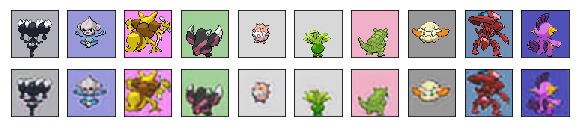

In [12]:
X_test_decoded = autoencoder.predict(X_test)

show_images(X_test, X_test_decoded)

In [13]:
def add_noise(x, noise_factor=0.2):
    x = x + np.random.randn(*x.shape) * noise_factor
    x = x.clip(0., 1.)
    return x
    
X_train_noisy = add_noise(X_train, 0.2)
X_test_noisy  = add_noise(X_test, 0.2)

In [14]:
noise_autoencoder = convolutional_autoencoder()
noise_autoencoder.fit(
    X_train_noisy, X_train, 
    epochs=n_epochs, 
    batch_size=batch_size, 
    validation_data=(X_test_noisy, X_test)
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 32, 32, 16)        0         
__________

1568/1568 [==============================] - 1s 374us/step - loss: 0.0168 - val_loss: 0.0170
Epoch 63/200
1568/1568 [==============================] - 1s 377us/step - loss: 0.0167 - val_loss: 0.0170
Epoch 64/200
1568/1568 [==============================] - 1s 367us/step - loss: 0.0167 - val_loss: 0.0170
Epoch 65/200
1568/1568 [==============================] - 1s 369us/step - loss: 0.0167 - val_loss: 0.0169
Epoch 66/200
1568/1568 [==============================] - 1s 369us/step - loss: 0.0166 - val_loss: 0.0171
Epoch 67/200
1568/1568 [==============================] - 1s 370us/step - loss: 0.0167 - val_loss: 0.0170
Epoch 68/200
1568/1568 [==============================] - 1s 371us/step - loss: 0.0166 - val_loss: 0.0168
Epoch 69/200
1568/1568 [==============================] - 1s 365us/step - loss: 0.0166 - val_loss: 0.0169
Epoch 70/200
1568/1568 [==============================] - 1s 362us/step - loss: 0.0165 - val_loss: 0.0168
Epoch 71/200
1568/1568 [==============================] - 1

1568/1568 [==============================] - 1s 366us/step - loss: 0.0155 - val_loss: 0.0157
Epoch 140/200
1568/1568 [==============================] - 1s 365us/step - loss: 0.0154 - val_loss: 0.0157
Epoch 141/200
1568/1568 [==============================] - 1s 369us/step - loss: 0.0154 - val_loss: 0.0157
Epoch 142/200
1568/1568 [==============================] - 1s 369us/step - loss: 0.0154 - val_loss: 0.0157
Epoch 143/200
1568/1568 [==============================] - 1s 365us/step - loss: 0.0154 - val_loss: 0.0158
Epoch 144/200
1568/1568 [==============================] - 1s 364us/step - loss: 0.0155 - val_loss: 0.0157
Epoch 145/200
1568/1568 [==============================] - 1s 364us/step - loss: 0.0155 - val_loss: 0.0163
Epoch 146/200
1568/1568 [==============================] - 1s 365us/step - loss: 0.0156 - val_loss: 0.0159
Epoch 147/200
1568/1568 [==============================] - 1s 365us/step - loss: 0.0154 - val_loss: 0.0157
Epoch 148/200
1568/1568 [==========================

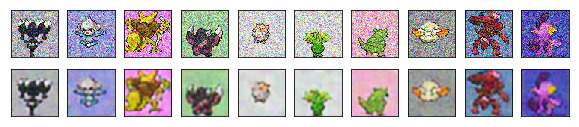

In [15]:
X_test_decoded = noise_autoencoder.predict(X_test_noisy)

show_images(X_test_noisy, X_test_decoded)